Feature Engineering is a key part in any ML problem and I think it will play a major role in this one as well.

So in this notebook, I am trying to create different types of features using the given data and build an XGBoost model using the same to look at the feature importance.

PS: Not all the variables will be useful. This is just about FE ideas. Please do proper validation and then use them :)

Let us start with importing the necessary modules.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
import xgboost as xgb
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

In [3]:
data_dir = '/Users/Ira/workspace/data/Sberbank_Housing_Market'
train_df = pd.read_csv(data_dir+"/train.csv", parse_dates=['timestamp'])
test_df = pd.read_csv(data_dir+"/test.csv", parse_dates=['timestamp'])
macro_df = pd.read_csv(data_dir+"/macro.csv", parse_dates=['timestamp'])
train_df = pd.merge(train_df, macro_df, how='left', on='timestamp')
test_df = pd.merge(test_df, macro_df, how='left', on='timestamp')
print(train_df.shape, test_df.shape)

# truncate the extreme values in price_doc #
ulimit = np.percentile(train_df.price_doc.values, 99)
llimit = np.percentile(train_df.price_doc.values, 1)
train_df['price_doc'].ix[train_df['price_doc']>ulimit] = ulimit
train_df['price_doc'].ix[train_df['price_doc']<llimit] = llimit

(30471, 391) (7662, 390)


As seen from this notebook, there are few categorical variables in the train data. 

So we can convert them into numerical variables by label encoding.

In [4]:
for f in train_df.columns:
    if train_df[f].dtype=='object':
        print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values.astype('str')) + list(test_df[f].values.astype('str')))
        train_df[f] = lbl.transform(list(train_df[f].values.astype('str')))
        test_df[f] = lbl.transform(list(test_df[f].values.astype('str')))

product_type
sub_area
culture_objects_top_25
thermal_power_plant_raion
incineration_raion
oil_chemistry_raion
radiation_raion
railroad_terminal_raion
big_market_raion
nuclear_reactor_raion
detention_facility_raion
water_1line
big_road1_1line
railroad_1line
ecology
child_on_acc_pre_school
modern_education_share
old_education_build_share


We also have some null values in the dataset. So one feature idea could be to use the count of nulls in the row.

/Users/Ira/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


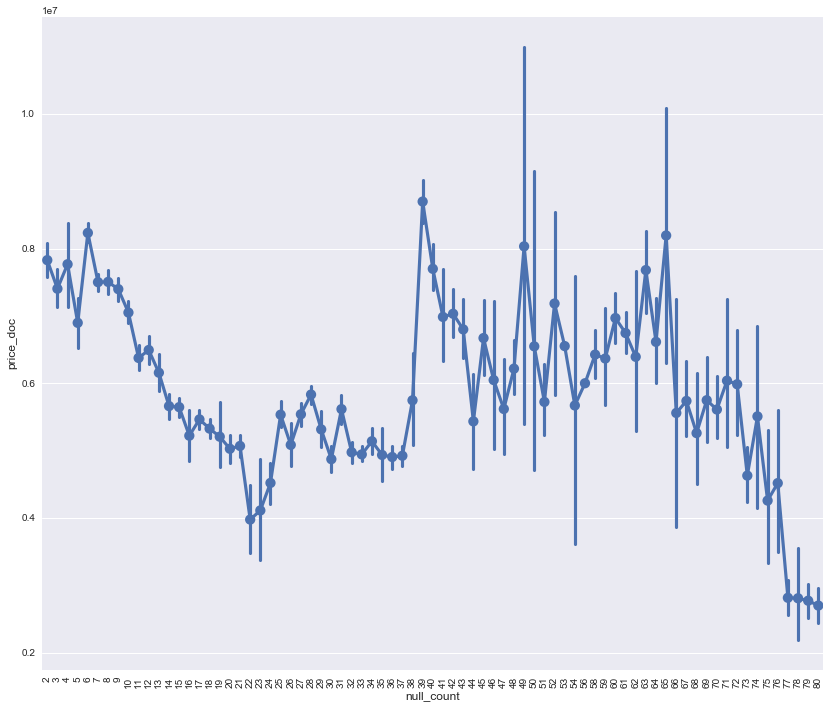

In [7]:
train_df["null_count"] = train_df.isnull().sum(axis=1)
test_df["null_count"] = test_df.isnull().sum(axis=1)

plt.figure(figsize=(14,12))
sns.pointplot(x='null_count', y='price_doc', data=train_df)
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('null_count', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Now let us impute the missing values with some value which is outside the range of values of the column, say -99.

In [8]:
train_df.fillna(-99, inplace=True)
test_df.fillna(-99, inplace=True)

We have a timestamp variable in the dataset and time could be one of an important factor determining the price. 

So let us extract some features out of the timestamp variable.

/Users/Ira/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


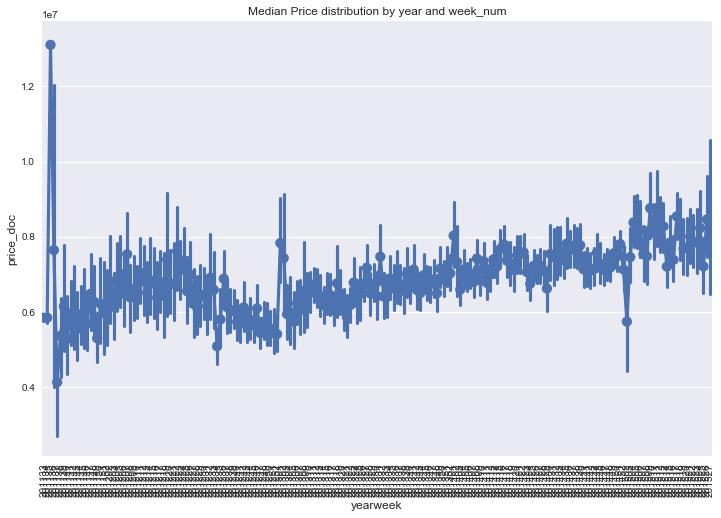

In [10]:
# year and month #
train_df["yearmonth"] = train_df["timestamp"].dt.year*100 + train_df["timestamp"].dt.month
test_df["yearmonth"] = test_df["timestamp"].dt.year*100 + test_df["timestamp"].dt.month

# year and week #
train_df["yearweek"] = train_df["timestamp"].dt.year*100 + train_df["timestamp"].dt.weekofyear
test_df["yearweek"] = test_df["timestamp"].dt.year*100 + test_df["timestamp"].dt.weekofyear

# year #
train_df["year"] = train_df["timestamp"].dt.year
test_df["year"] = test_df["timestamp"].dt.year

# month of year #
train_df["month_of_year"] = train_df["timestamp"].dt.month
test_df["month_of_year"] = test_df["timestamp"].dt.month

# week of year #
train_df["week_of_year"] = train_df["timestamp"].dt.weekofyear
test_df["week_of_year"] = test_df["timestamp"].dt.weekofyear

# day of week #
train_df["day_of_week"] = train_df["timestamp"].dt.weekday
test_df["day_of_week"] = test_df["timestamp"].dt.weekday


plt.figure(figsize=(12,8))
sns.pointplot(x='yearweek', y='price_doc', data=train_df)
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('yearweek', fontsize=12)
plt.title('Median Price distribution by year and week_num')
plt.xticks(rotation='vertical')
plt.show()

/Users/Ira/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


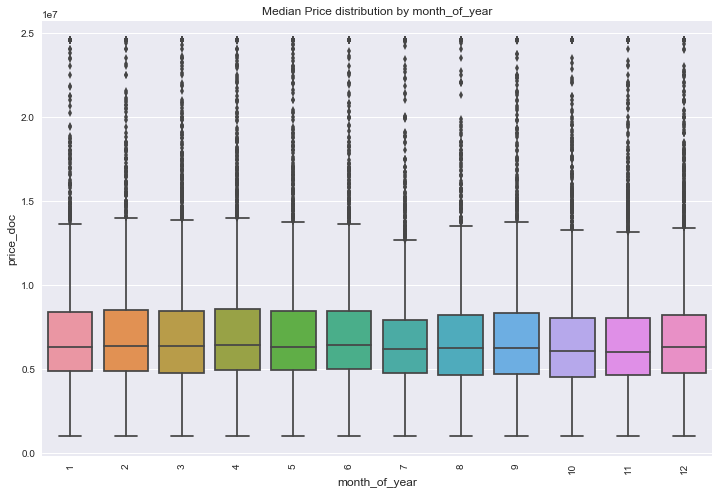

In [11]:
plt.figure(figsize=(12,8))
sns.boxplot(x='month_of_year', y='price_doc', data=train_df)
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('month_of_year', fontsize=12)
plt.title('Median Price distribution by month_of_year')
plt.xticks(rotation='vertical')
plt.show()

/Users/Ira/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


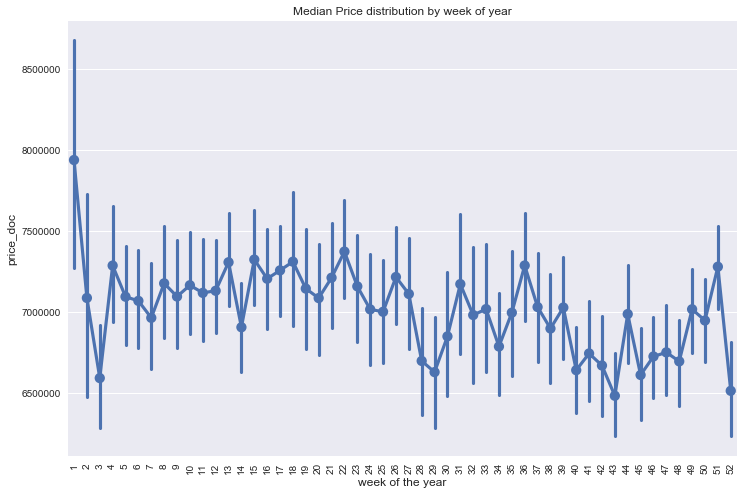

In [12]:
plt.figure(figsize=(12,8))
sns.pointplot(x='week_of_year', y='price_doc', data=train_df)
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('week of the year', fontsize=12)
plt.title('Median Price distribution by week of year')
plt.xticks(rotation='vertical')
plt.show()

/Users/Ira/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


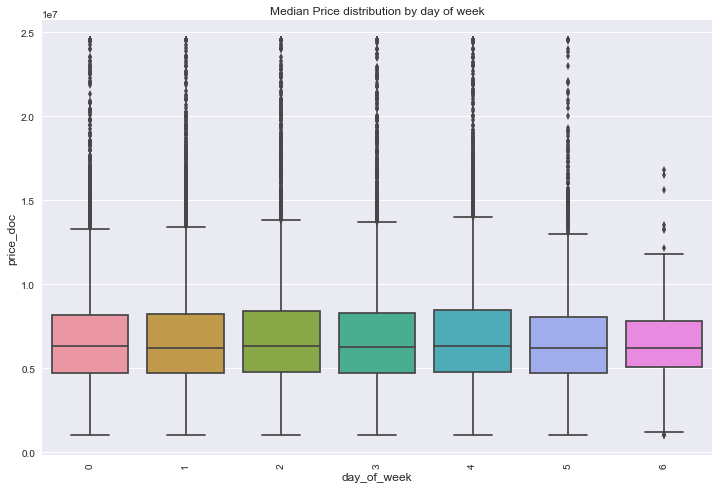

In [13]:
plt.figure(figsize=(12,8))
sns.boxplot(x='day_of_week', y='price_doc', data=train_df)
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('day_of_week', fontsize=12)
plt.title('Median Price distribution by day of week')
plt.xticks(rotation='vertical')
plt.show()

Also from the simple exploration notebook, we have seen that area of the property is the top variables. 

So creating some more features might be helpful.

Let us create some ratio variables around it.

In [14]:
# ratio of living area to full area #
train_df["ratio_life_sq_full_sq"] = train_df["life_sq"] / np.maximum(train_df["full_sq"].astype("float"),1)
test_df["ratio_life_sq_full_sq"] = test_df["life_sq"] / np.maximum(test_df["full_sq"].astype("float"),1)
train_df["ratio_life_sq_full_sq"].ix[train_df["ratio_life_sq_full_sq"]<0] = 0
train_df["ratio_life_sq_full_sq"].ix[train_df["ratio_life_sq_full_sq"]>1] = 1
test_df["ratio_life_sq_full_sq"].ix[test_df["ratio_life_sq_full_sq"]<0] = 0
test_df["ratio_life_sq_full_sq"].ix[test_df["ratio_life_sq_full_sq"]>1] = 1

# ratio of kitchen area to living area #
train_df["ratio_kitch_sq_life_sq"] = train_df["kitch_sq"] / np.maximum(train_df["life_sq"].astype("float"),1)
test_df["ratio_kitch_sq_life_sq"] = test_df["kitch_sq"] / np.maximum(test_df["life_sq"].astype("float"),1)
train_df["ratio_kitch_sq_life_sq"].ix[train_df["ratio_kitch_sq_life_sq"]<0] = 0
train_df["ratio_kitch_sq_life_sq"].ix[train_df["ratio_kitch_sq_life_sq"]>1] = 1
test_df["ratio_kitch_sq_life_sq"].ix[test_df["ratio_kitch_sq_life_sq"]<0] = 0
test_df["ratio_kitch_sq_life_sq"].ix[test_df["ratio_kitch_sq_life_sq"]>1] = 1

# ratio of kitchen area to full area #
train_df["ratio_kitch_sq_full_sq"] = train_df["kitch_sq"] / np.maximum(train_df["full_sq"].astype("float"),1)
test_df["ratio_kitch_sq_full_sq"] = test_df["kitch_sq"] / np.maximum(test_df["full_sq"].astype("float"),1)
train_df["ratio_kitch_sq_full_sq"].ix[train_df["ratio_kitch_sq_full_sq"]<0] = 0
train_df["ratio_kitch_sq_full_sq"].ix[train_df["ratio_kitch_sq_full_sq"]>1] = 1
test_df["ratio_kitch_sq_full_sq"].ix[test_df["ratio_kitch_sq_full_sq"]<0] = 0
test_df["ratio_kitch_sq_full_sq"].ix[test_df["ratio_kitch_sq_full_sq"]>1] = 1

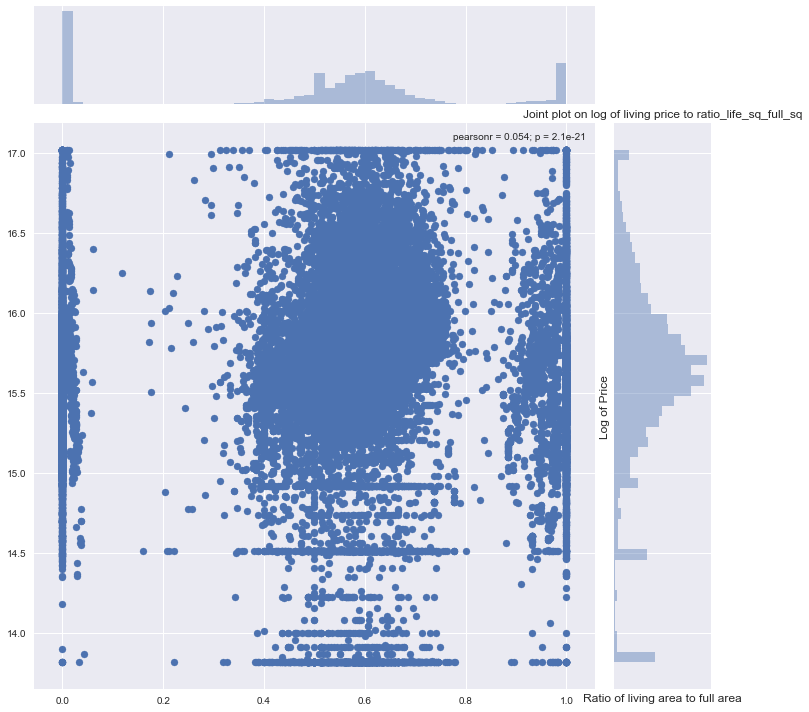

In [15]:
plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.ratio_life_sq_full_sq.values, y=np.log1p(train_df.price_doc.values), size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Ratio of living area to full area', fontsize=12)
plt.title("Joint plot on log of living price to ratio_life_sq_full_sq")
plt.show()

/Users/Ira/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


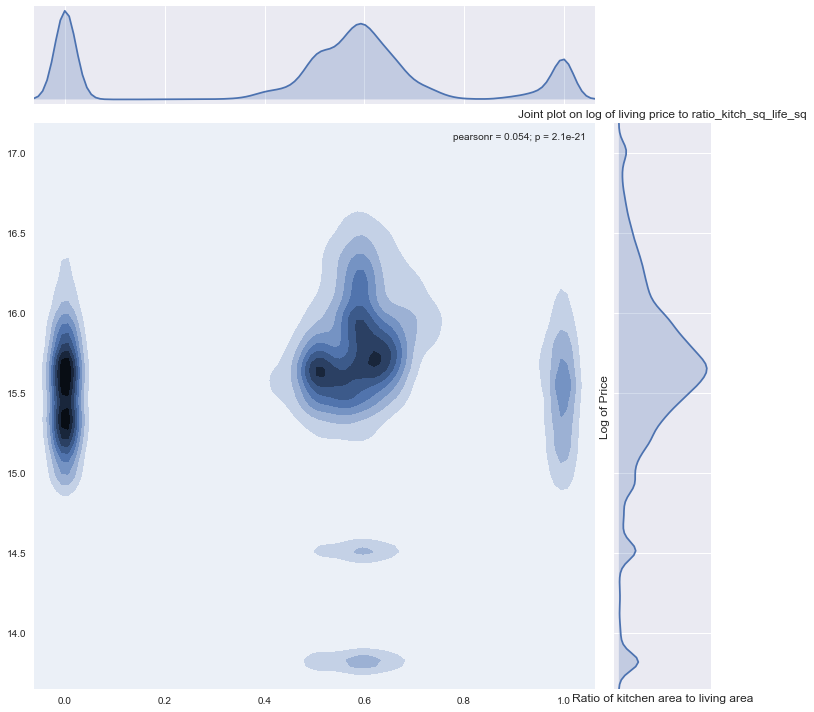

In [16]:
plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.ratio_life_sq_full_sq.values, y=np.log1p(train_df.price_doc.values), 
              kind='kde',size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Ratio of kitchen area to living area', fontsize=12)
plt.title("Joint plot on log of living price to ratio_kitch_sq_life_sq")
plt.show()

/Users/Ira/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


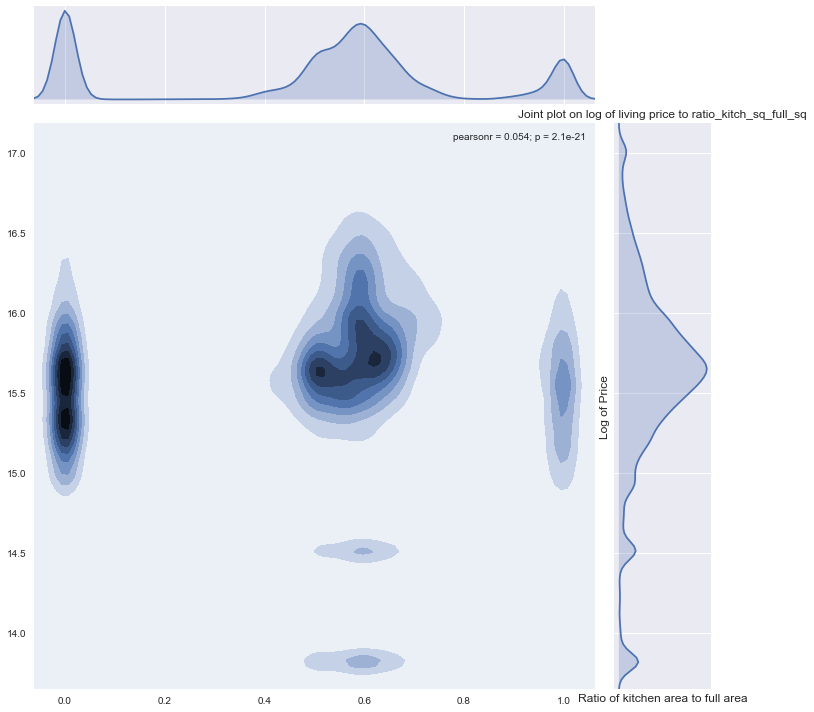

In [17]:
plt.figure(figsize=(12,12))
sns.jointplot(x=train_df.ratio_life_sq_full_sq.values, y=np.log1p(train_df.price_doc.values), 
              kind='kde',size=10)
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Ratio of kitchen area to full area', fontsize=12)
plt.title("Joint plot on log of living price to ratio_kitch_sq_full_sq")
plt.show()

Also the next important variables from EDA are floor and max_floor. So let us create two variables

1. Floor number of the house to the total number of floors
2. Number of floor from the top

In [18]:
#floor of the house to the total number of floors in the house #
train_df["ratio_floor_max_floor"] = train_df["floor"] / train_df["max_floor"].astype("float")
test_df["ratio_floor_max_floor"] = test_df["floor"] / test_df["max_floor"].astype("float")

# num of floor from top #
train_df["floor_from_top"] = train_df["max_floor"] - train_df["floor"]
test_df["floor_from_top"] = test_df["max_floor"] - test_df["floor"]

One more variable from floor area could be the difference between full area and living area.

In [19]:
train_df["extra_sq"] = train_df["full_sq"] - train_df["life_sq"]
test_df["extra_sq"] = test_df["full_sq"] - test_df["life_sq"]

Age of building might have an impact in the rental price and so we can add that one as well.

In [20]:
train_df["age_of_building"] = train_df["build_year"] - train_df["year"]
test_df["age_of_building"] = test_df["build_year"] - test_df["year"]

Price of the house could also be affected by the availability of other houses at the same time period. 

So creating a count variable on the number of houses at the given time period might help.

In [21]:
def add_count(df, group_col):
    grouped_df = df.groupby(group_col)["id"].aggregate("count").reset_index()
    grouped_df.columns = [group_col, "count_"+group_col]
    df = pd.merge(df, grouped_df, on=group_col, how="left")
    return df

train_df = add_count(train_df, "yearmonth")
test_df = add_count(test_df, "yearmonth")

train_df = add_count(train_df, "yearweek")
test_df = add_count(test_df, "yearweek")

Since schools generally play an important role in house hunting, let us create some variables around school.

In [22]:
train_df["ratio_preschool"] = train_df["children_preschool"] / train_df["preschool_quota"].astype("float")
test_df["ratio_preschool"] = test_df["children_preschool"] / test_df["preschool_quota"].astype("float")

train_df["ratio_school"] = train_df["children_school"] / train_df["school_quota"].astype("float")
test_df["ratio_school"] = test_df["children_school"] / test_df["school_quota"].astype("float")

We could potentially add more variables like this. But for now let us start with model building using these additional variables. 

Let us drop the variables which are not needed in model building.

In [23]:
train_X = train_df.drop(["id", "timestamp", "price_doc"], axis=1)
test_X = test_df.drop(["id", "timestamp"] , axis=1)

Since our metric is "RMSLE", 
let us use log of the target variable for model building rather than using the actual target variable.

In [25]:
train_y = np.log1p(train_df.price_doc.values)

# Validation Methodology:

But before building our models, let us do some local validation by splitting the train dataset.

In this competition, the train and test set are from different time periods and so let us use the last 1 year as validation set for building our models and rest as model development set.

In [26]:
val_time = 201407
dev_indices = np.where(train_X["yearmonth"]<val_time)
val_indices = np.where(train_X["yearmonth"]>=val_time)
dev_X = train_X.ix[dev_indices]
val_X = train_X.ix[val_indices]
dev_y = train_y[dev_indices]
val_y = train_y[val_indices]
print(dev_X.shape, val_X.shape)

(20483, 406) (9988, 406)


Let us build xgboost model using these variables and check the score.

In [27]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 4,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'min_child_weight':1,
    'silent': 1,
    'seed':0
}

xgtrain = xgb.DMatrix(dev_X, dev_y, feature_names=dev_X.columns)
xgtest = xgb.DMatrix(val_X, val_y, feature_names=val_X.columns)
watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
num_rounds = 100 # Increase the number of rounds while running in local
model = xgb.train(xgb_params, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=5)

[0]	train-rmse:14.3232	test-rmse:14.4524
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
[5]	train-rmse:11.0894	test-rmse:11.2104
[10]	train-rmse:8.58793	test-rmse:8.70383
[15]	train-rmse:6.65399	test-rmse:6.76542
[20]	train-rmse:5.15889	test-rmse:5.26732
[25]	train-rmse:4.00494	test-rmse:4.1095
[30]	train-rmse:3.11495	test-rmse:3.21194
[35]	train-rmse:2.43009	test-rmse:2.52159
[40]	train-rmse:1.9056	test-rmse:1.99088
[45]	train-rmse:1.50543	test-rmse:1.58433
[50]	train-rmse:1.2034	test-rmse:1.27449
[55]	train-rmse:0.978673	test-rmse:1.04313
[60]	train-rmse:0.813957	test-rmse:0.876836
[65]	train-rmse:0.696127	test-rmse:0.749333
[70]	train-rmse:0.614473	test-rmse:0.656916
[75]	train-rmse:0.559035	test-rmse:0.5917
[80]	train-rmse:0.522599	test-rmse:0.549238
[85]	train-rmse:0.498923	test-rmse:0.516937
[90]	train-rmse:0.483767	test-rmse:0.494196
[95]	train-rmse:0.473652	test-rmse:0.478512
[99]	tr

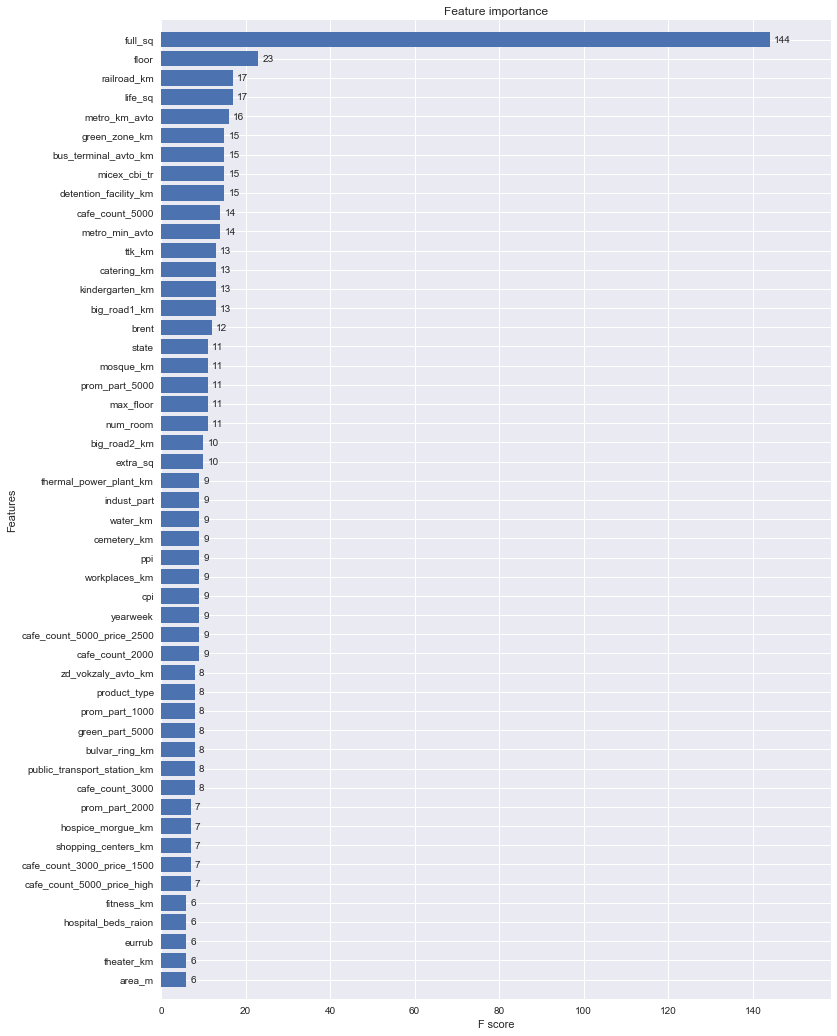

In [28]:
# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()